# NFL Coaching Tenure Classification

This notebook implements machine learning models to predict NFL coaching tenure classification using stratified 10-fold cross-validation.

**Target Classes:**
- 0: Short tenure (≤2 years)
- 1: Medium tenure (3-4 years) 
- 2: Long tenure (5+ years)

**Primary Metric:** Macro-averaged one-versus-rest AUROC

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries loaded successfully")

Libraries loaded successfully


## Data Loading and Preprocessing

In [126]:
# Load the dataset
df = pd.read_csv('master_data.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nTenure class distribution:")
print(df['Coach Tenure Class'].value_counts().sort_index())

Dataset shape: (657, 155)

Tenure class distribution:
-1     21
 0    311
 1    170
 2    155
Name: Coach Tenure Class, dtype: int64


In [127]:
# Separate training data (exclude tenure class -1) and prediction data
train_mask = df['Coach Tenure Class'] != -1
df_train = df[train_mask].copy()
df_predict = df[~train_mask].copy()

print(f"Training instances: {len(df_train)}")
print(f"Prediction instances (tenure class -1): {len(df_predict)}")
print(f"\nTraining set tenure distribution:")
print(df_train['Coach Tenure Class'].value_counts().sort_index())

Training instances: 636
Prediction instances (tenure class -1): 21

Training set tenure distribution:
0    311
1    170
2    155
Name: Coach Tenure Class, dtype: int64


In [128]:
# Feature columns (Feature 1 through Feature 150)
feature_cols = [f'Feature {i}' for i in range(1, 151)]
target_col = 'Coach Tenure Class'

# Extract features and target for training
X_train = df_train[feature_cols].copy()
y_train = df_train[target_col].copy()

# Extract features for prediction
X_predict = df_predict[feature_cols].copy()

print(f"Training features shape: {X_train.shape}")
print(f"Prediction features shape: {X_predict.shape}")

Training features shape: (636, 150)
Prediction features shape: (21, 150)


## Data Quality Analysis

In [129]:
# Check for missing values
missing_counts = X_train.isnull().sum()
features_with_missing = missing_counts[missing_counts > 0]

print(f"Features with missing values: {len(features_with_missing)}")
if len(features_with_missing) > 0:
    print("\nTop 10 features with most missing values:")
    print(features_with_missing.sort_values(ascending=False).head(10))
    
    # Fill missing values with median
    X_train = X_train.fillna(X_train.median())
    X_predict = X_predict.fillna(X_train.median())  # Use training median for consistency
    print("\nMissing values filled with median")
else:
    print("No missing values found")

Features with missing values: 142

Top 10 features with most missing values:
Feature 95     619
Feature 98     619
Feature 130    619
Feature 129    619
Feature 128    619
Feature 100    619
Feature 96     619
Feature 97     619
Feature 99     619
Feature 132    619
dtype: int64

Missing values filled with median


In [130]:
# Feature statistics
print("Feature statistics:")
print(f"Mean: {X_train.mean().mean():.4f}")
print(f"Std: {X_train.std().mean():.4f}")
print(f"Min: {X_train.min().min():.4f}")
print(f"Max: {X_train.max().max():.4f}")

# Check for constant features
constant_features = X_train.columns[X_train.std() == 0]
print(f"\nConstant features: {len(constant_features)}")
if len(constant_features) > 0:
    print(f"Removing constant features: {list(constant_features)}")
    X_train = X_train.drop(columns=constant_features)
    X_predict = X_predict.drop(columns=constant_features)

Feature statistics:
Mean: 0.3498
Std: 0.4492
Min: -2.8581
Max: 67.0000

Constant features: 0


## Class Distribution Visualization

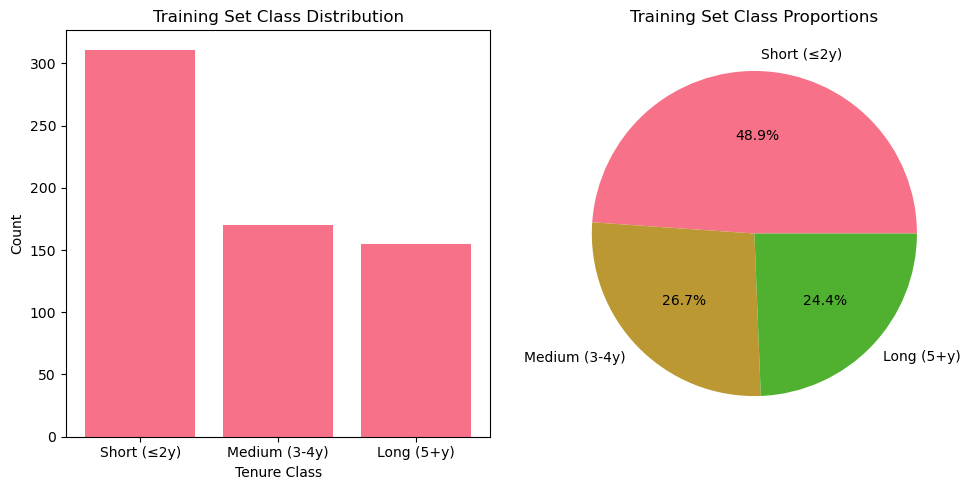

Class proportions:
Class 0: 0.489 (311 instances)
Class 1: 0.267 (170 instances)
Class 2: 0.244 (155 instances)


In [131]:
# Visualize class distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
tenure_counts = y_train.value_counts().sort_index()
plt.bar(tenure_counts.index, tenure_counts.values)
plt.xlabel('Tenure Class')
plt.ylabel('Count')
plt.title('Training Set Class Distribution')
plt.xticks([0, 1, 2], ['Short (≤2y)', 'Medium (3-4y)', 'Long (5+y)'])

plt.subplot(1, 2, 2)
plt.pie(tenure_counts.values, labels=['Short (≤2y)', 'Medium (3-4y)', 'Long (5+y)'], autopct='%1.1f%%')
plt.title('Training Set Class Proportions')

plt.tight_layout()
plt.show()

# Class balance statistics
class_proportions = y_train.value_counts(normalize=True).sort_index()
print("Class proportions:")
for i, prop in enumerate(class_proportions):
    print(f"Class {i}: {prop:.3f} ({tenure_counts[i]} instances)")

## Feature Scaling

In [132]:
# Scale features for SVM (XGBoost doesn't require scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_predict_scaled = scaler.transform(X_predict)

print(f"Features scaled. Shape: {X_train_scaled.shape}")
print(f"Scaled features - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")

Features scaled. Shape: (636, 150)
Scaled features - Mean: 0.000000, Std: 1.000000


## Model Definition and Cross-Validation Setup

In [133]:
# Define models
models = {
    'XGBoost': XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        eval_metric='mlogloss'
    ),
    'SVM': SVC(
        kernel='rbf',
        probability=True,  # Enable probability estimates for AUROC
        random_state=42
    )
}

# Set up stratified 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print("Models defined and 10-fold stratified CV setup complete")

Models defined and 10-fold stratified CV setup complete


## Custom AUROC Scoring Function

In [134]:
from sklearn.metrics import make_scorer

def macro_ovr_auroc(y_true, y_pred_proba):
    """Calculate macro-averaged one-vs-rest AUROC"""
    return roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')

# Create scorer
auroc_scorer = make_scorer(macro_ovr_auroc, needs_proba=True)
print("Custom AUROC scorer created")

Custom AUROC scorer created


## Hyperparameter Optimization with GridSearchCV

In [135]:
# Evaluate baseline models using cross-validation
cv_results = {}

for name, model in models.items():
    print(f"\nEvaluating baseline {name}...")
    
    # Use scaled features for SVM, original for XGBoost
    X_cv = X_train_scaled if name == 'SVM' else X_train
    
    # Cross-validation AUROC scores
    auroc_scores = cross_val_score(model, X_cv, y_train, cv=cv, scoring=auroc_scorer)
    
    cv_results[name] = {
        'auroc_scores': auroc_scores,
        'auroc_mean': auroc_scores.mean(),
        'auroc_std': auroc_scores.std()
    }
    
    print(f"{name} (Baseline) - Macro AUROC: {auroc_scores.mean():.4f} ± {auroc_scores.std():.4f}")
    print(f"Individual fold scores: {[f'{score:.4f}' for score in auroc_scores]}")


Evaluating baseline XGBoost...
XGBoost (Baseline) - Macro AUROC: 0.6521 ± 0.0600
Individual fold scores: ['0.7299', '0.7159', '0.6786', '0.6248', '0.5667', '0.6128', '0.5976', '0.7456', '0.6590', '0.5901']

Evaluating baseline SVM...
SVM (Baseline) - Macro AUROC: 0.6465 ± 0.0607
Individual fold scores: ['0.7039', '0.7266', '0.5820', '0.5888', '0.5610', '0.6860', '0.6340', '0.6990', '0.7047', '0.5795']


## Baseline Cross-Validation Evaluation

In [136]:
# Define hyperparameter grids for optimization
param_grids = {
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.05, 0.1, 0.15],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'kernel': ['rbf', 'poly', 'sigmoid']
    }
}

print("Hyperparameter grids defined:")
for model_name, grid in param_grids.items():
    total_combinations = np.prod([len(values) for values in grid.values()])
    print(f"- {model_name}: {total_combinations} combinations")
    for param, values in grid.items():
        print(f"  {param}: {values}")
    print()

Hyperparameter grids defined:
- XGBoost: 324 combinations
  n_estimators: [100, 200, 300]
  max_depth: [3, 4, 5, 6]
  learning_rate: [0.05, 0.1, 0.15]
  subsample: [0.8, 0.9, 1.0]
  colsample_bytree: [0.8, 0.9, 1.0]

- SVM: 72 combinations
  C: [0.1, 1, 10, 100]
  gamma: ['scale', 'auto', 0.001, 0.01, 0.1, 1]
  kernel: ['rbf', 'poly', 'sigmoid']



In [137]:
# Perform GridSearchCV for each model
print("Starting hyperparameter optimization...")
print("This may take several minutes depending on your hardware.\n")

# Initialize models for grid search
base_models = {
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'SVM': SVC(probability=True, random_state=42)
}

# Set up inner CV for grid search (5-fold to balance speed vs. accuracy)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store grid search results
grid_search_results = {}
best_models = {}

for model_name in base_models.keys():
    print(f"Optimizing {model_name}...")
    
    # Select appropriate feature set
    X_gs = X_train_scaled if model_name == 'SVM' else X_train
    
    # Create grid search object
    grid_search = GridSearchCV(
        estimator=base_models[model_name],
        param_grid=param_grids[model_name],
        scoring=auroc_scorer,
        cv=inner_cv,
        n_jobs=-1,  # Use all available cores
        verbose=1,
        return_train_score=False
    )
    
    # Fit grid search
    grid_search.fit(X_gs, y_train)
    
    # Store results
    grid_search_results[model_name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'cv_results': grid_search.cv_results_
    }
    best_models[model_name] = grid_search.best_estimator_
    
    print(f"{model_name} optimization complete!")
    print(f"Best CV Score: {grid_search.best_score_:.4f}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print("-" * 50)

Starting hyperparameter optimization...
This may take several minutes depending on your hardware.

Optimizing XGBoost...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  3.1min finished


XGBoost optimization complete!
Best CV Score: 0.6887
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
--------------------------------------------------
Optimizing SVM...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   19.6s finished


SVM optimization complete!
Best CV Score: 0.6623
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
--------------------------------------------------


HYPERPARAMETER OPTIMIZATION RESULTS
   Model  Best_CV_Score                                                                                          Best_Parameters
 XGBoost       0.688696  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
     SVM       0.662289                                                                  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}



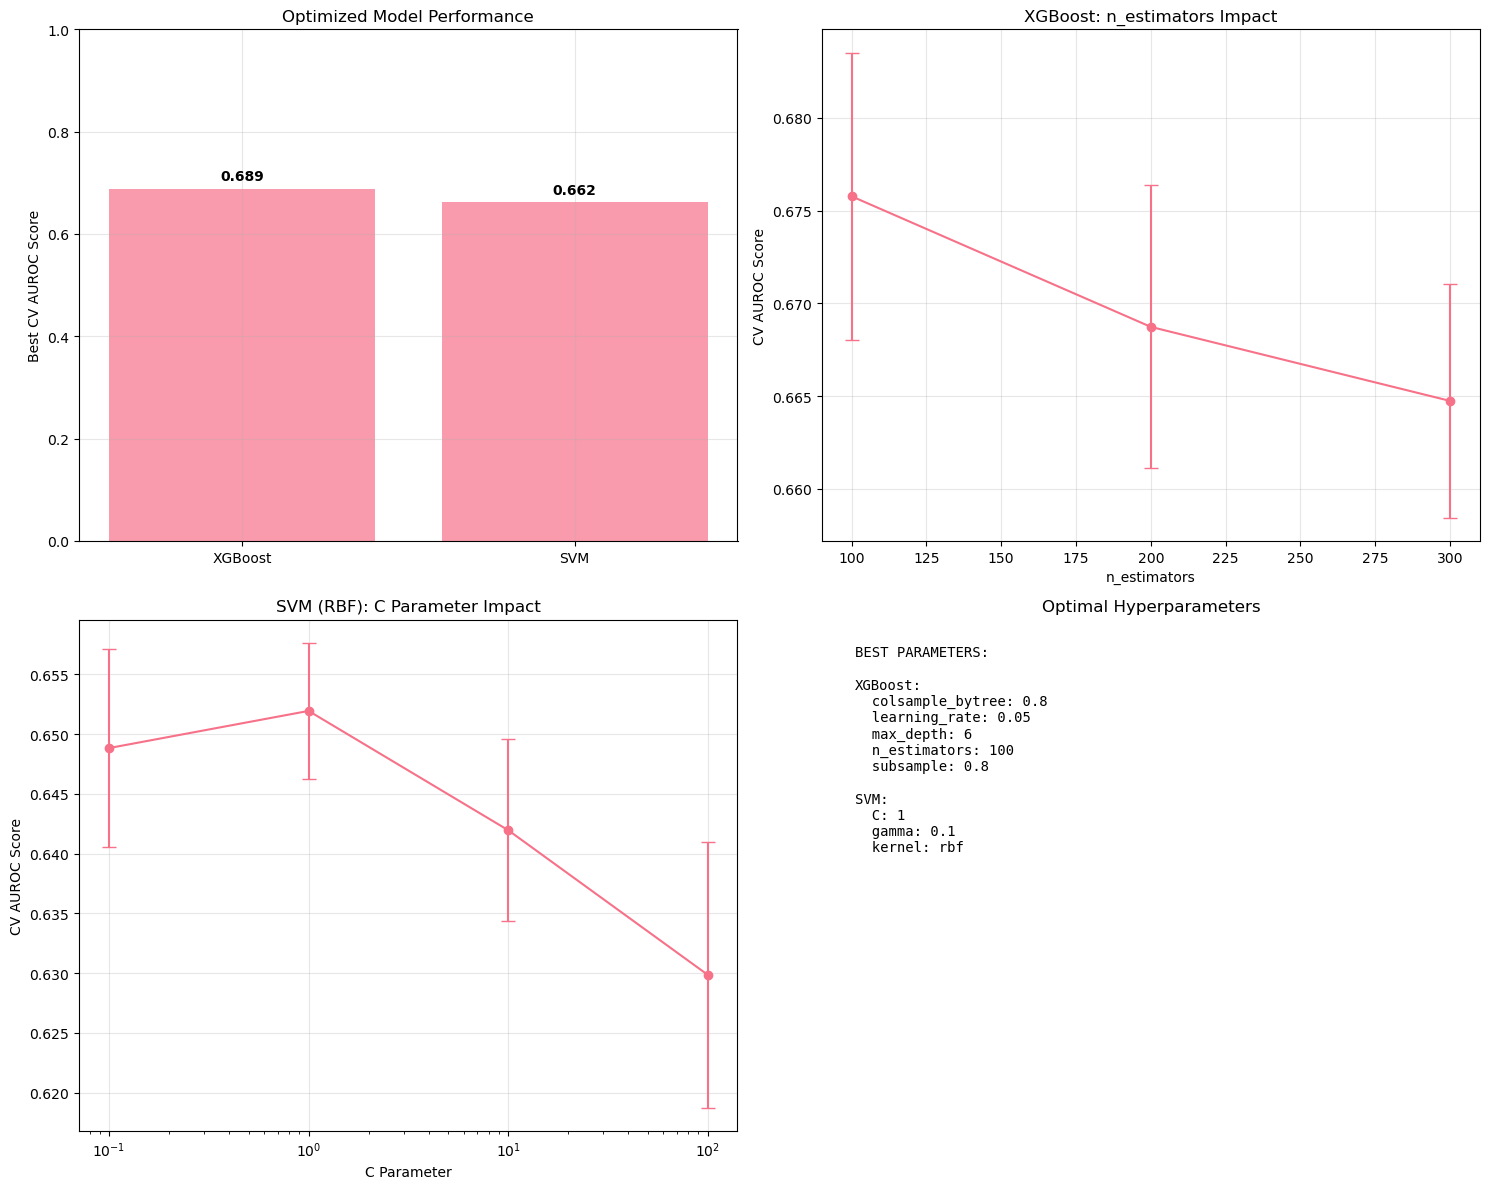

In [138]:
# Visualize hyperparameter optimization results
print("HYPERPARAMETER OPTIMIZATION RESULTS")
print("=" * 50)

# Summary table
optimization_summary = []
for model_name, results in grid_search_results.items():
    optimization_summary.append({
        'Model': model_name,
        'Best_CV_Score': results['best_score'],
        'Best_Parameters': str(results['best_params'])
    })

summary_df = pd.DataFrame(optimization_summary)
print(summary_df.to_string(index=False))
print()

# Plot comparison of optimized vs baseline models
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Best scores comparison
ax1 = axes[0, 0]
model_names = list(grid_search_results.keys())
best_scores = [grid_search_results[name]['best_score'] for name in model_names]
bars = ax1.bar(model_names, best_scores, alpha=0.7)
ax1.set_ylabel('Best CV AUROC Score')
ax1.set_title('Optimized Model Performance')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, best_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# Parameter sensitivity for XGBoost (if available)
if 'XGBoost' in grid_search_results:
    ax2 = axes[0, 1]
    xgb_results = pd.DataFrame(grid_search_results['XGBoost']['cv_results'])
    
    # Plot n_estimators vs score
    param_analysis = xgb_results.groupby('param_n_estimators')['mean_test_score'].agg(['mean', 'std'])
    ax2.errorbar(param_analysis.index, param_analysis['mean'], yerr=param_analysis['std'], 
                marker='o', capsize=5)
    ax2.set_xlabel('n_estimators')
    ax2.set_ylabel('CV AUROC Score')
    ax2.set_title('XGBoost: n_estimators Impact')
    ax2.grid(True, alpha=0.3)

# Parameter sensitivity for SVM (if available)
if 'SVM' in grid_search_results:
    ax3 = axes[1, 0]
    svm_results = pd.DataFrame(grid_search_results['SVM']['cv_results'])
    
    # Plot C parameter vs score for rbf kernel
    rbf_results = svm_results[svm_results['param_kernel'] == 'rbf']
    if not rbf_results.empty:
        param_analysis = rbf_results.groupby('param_C')['mean_test_score'].agg(['mean', 'std'])
        ax3.errorbar(param_analysis.index, param_analysis['mean'], yerr=param_analysis['std'], 
                    marker='o', capsize=5)
        ax3.set_xlabel('C Parameter')
        ax3.set_ylabel('CV AUROC Score')
        ax3.set_title('SVM (RBF): C Parameter Impact')
        ax3.set_xscale('log')
        ax3.grid(True, alpha=0.3)

# Best parameter values visualization
ax4 = axes[1, 1]
param_text = "BEST PARAMETERS:\n\n"
for model_name, results in grid_search_results.items():
    param_text += f"{model_name}:\n"
    for param, value in results['best_params'].items():
        param_text += f"  {param}: {value}\n"
    param_text += "\n"

ax4.text(0.05, 0.95, param_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace')
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
ax4.axis('off')
ax4.set_title('Optimal Hyperparameters')

plt.tight_layout()
plt.show()

In [139]:
# Evaluate optimized models using 10-fold cross-validation
print("Evaluating optimized models with 10-fold cross-validation...")
print("-" * 60)

# Set up outer CV for final evaluation (10-fold as requested)
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store final evaluation results
final_cv_results = {}

for model_name, best_model in best_models.items():
    print(f"\nEvaluating optimized {model_name}...")
    
    # Use appropriate feature set
    X_eval = X_train_scaled if model_name == 'SVM' else X_train
    
    # Cross-validation AUROC scores with optimized model
    auroc_scores = cross_val_score(best_model, X_eval, y_train, cv=outer_cv, scoring=auroc_scorer)
    
    final_cv_results[model_name] = {
        'auroc_scores': auroc_scores,
        'auroc_mean': auroc_scores.mean(),
        'auroc_std': auroc_scores.std(),
        'best_params': grid_search_results[model_name]['best_params']
    }
    
    print(f"{model_name} (Optimized) - Macro AUROC: {auroc_scores.mean():.4f} ± {auroc_scores.std():.4f}")
    print(f"Individual fold scores: {[f'{score:.4f}' for score in auroc_scores]}")

# Compare with baseline (if you want to show improvement)
print(f"\n{'='*60}")
print("OPTIMIZATION IMPACT SUMMARY")
print(f"{'='*60}")

for model_name in best_models.keys():
    optimized_score = final_cv_results[model_name]['auroc_mean']
    baseline_score = grid_search_results[model_name]['best_score']  # This is from 5-fold
    
    print(f"\n{model_name}:")
    print(f"  Optimized (10-fold): {optimized_score:.4f} ± {final_cv_results[model_name]['auroc_std']:.4f}")
    print(f"  Best from GridSearch (5-fold): {baseline_score:.4f}")
    print(f"  Best Parameters: {final_cv_results[model_name]['best_params']}")

Evaluating optimized models with 10-fold cross-validation...
------------------------------------------------------------

Evaluating optimized XGBoost...
XGBoost (Optimized) - Macro AUROC: 0.6772 ± 0.0504
Individual fold scores: ['0.7562', '0.7142', '0.6923', '0.6383', '0.5933', '0.6450', '0.6434', '0.7578', '0.6710', '0.6603']

Evaluating optimized SVM...
SVM (Optimized) - Macro AUROC: 0.6572 ± 0.0491
Individual fold scores: ['0.6633', '0.6984', '0.6651', '0.6117', '0.5736', '0.6813', '0.6231', '0.7217', '0.7268', '0.6074']

OPTIMIZATION IMPACT SUMMARY

XGBoost:
  Optimized (10-fold): 0.6772 ± 0.0504
  Best from GridSearch (5-fold): 0.6887
  Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}

SVM:
  Optimized (10-fold): 0.6572 ± 0.0491
  Best from GridSearch (5-fold): 0.6623
  Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


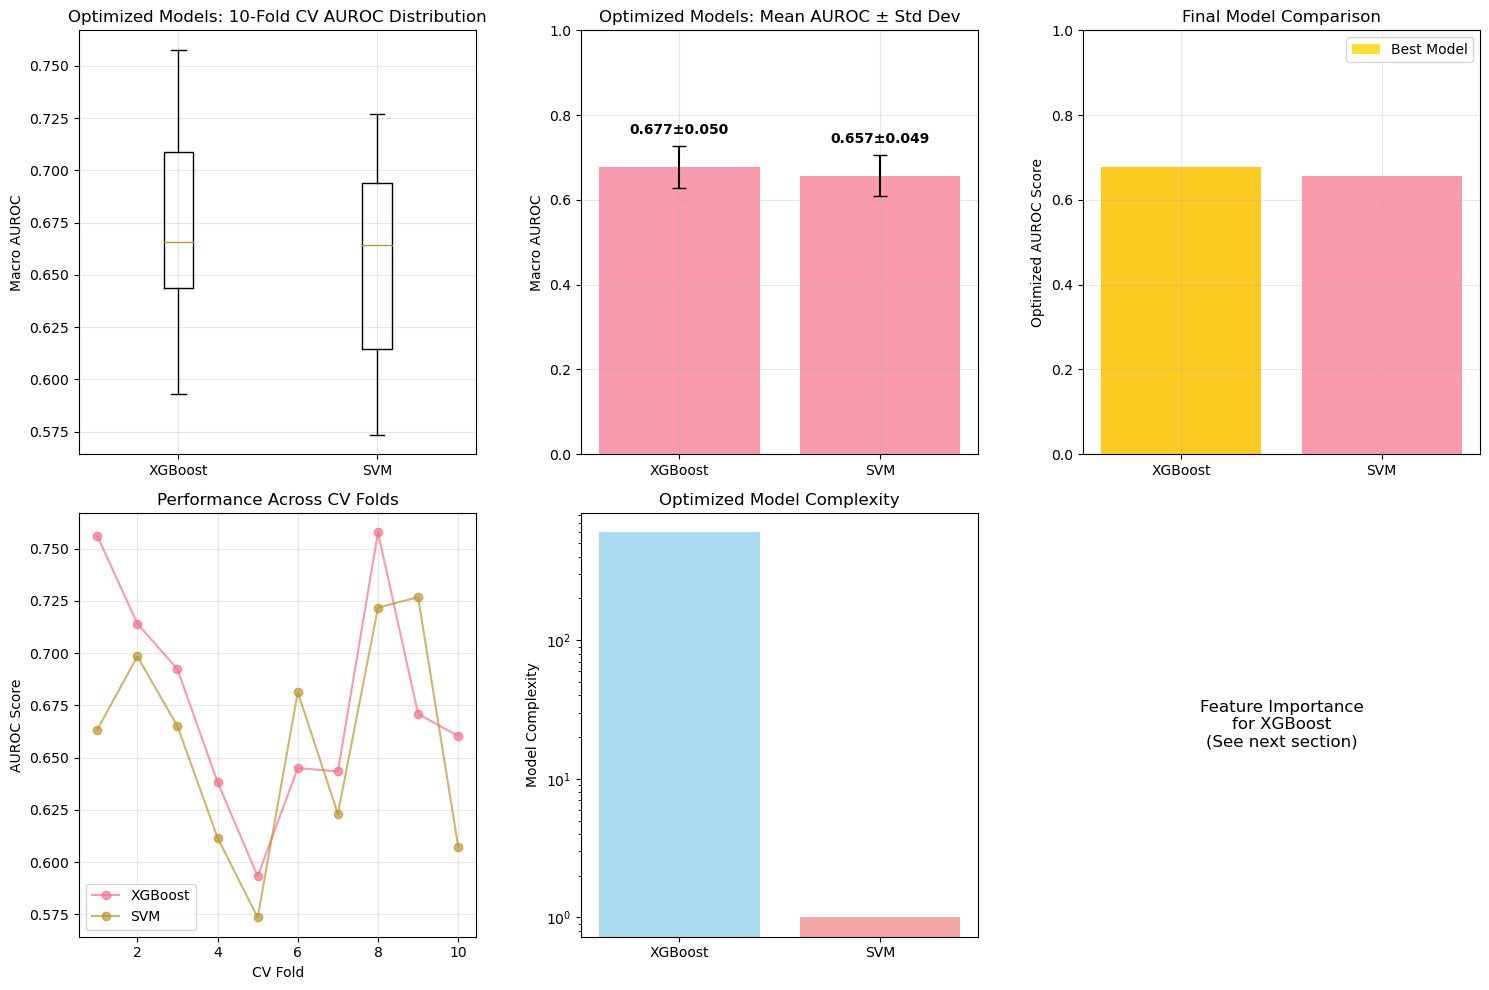

In [140]:
# Visualize optimized model results
plt.figure(figsize=(15, 10))

# Box plot of AUROC scores
plt.subplot(2, 3, 1)
auroc_data = [final_cv_results[name]['auroc_scores'] for name in best_models.keys()]
plt.boxplot(auroc_data, labels=best_models.keys())
plt.ylabel('Macro AUROC')
plt.title('Optimized Models: 10-Fold CV AUROC Distribution')
plt.grid(True, alpha=0.3)

# Bar plot of mean scores with error bars
plt.subplot(2, 3, 2)
names = list(best_models.keys())
means = [final_cv_results[name]['auroc_mean'] for name in names]
stds = [final_cv_results[name]['auroc_std'] for name in names]

bars = plt.bar(names, means, yerr=stds, capsize=5, alpha=0.7)
plt.ylabel('Macro AUROC')
plt.title('Optimized Models: Mean AUROC ± Std Dev')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, (mean, std) in enumerate(zip(means, stds)):
    plt.text(i, mean + std + 0.02, f'{mean:.3f}±{std:.3f}', 
             ha='center', va='bottom', fontweight='bold')

# Performance improvement comparison
plt.subplot(2, 3, 3)
if len(best_models) >= 2:
    model_names = list(best_models.keys())
    opt_scores = [final_cv_results[name]['auroc_mean'] for name in model_names]
    
    plt.bar(range(len(model_names)), opt_scores, alpha=0.7)
    plt.xticks(range(len(model_names)), model_names)
    plt.ylabel('Optimized AUROC Score')
    plt.title('Final Model Comparison')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    
    # Highlight best model
    best_idx = np.argmax(opt_scores)
    plt.bar(best_idx, opt_scores[best_idx], color='gold', alpha=0.8, label='Best Model')
    plt.legend()

# Learning curves or parameter sensitivity (placeholder for additional analysis)
plt.subplot(2, 3, 4)
fold_numbers = range(1, 11)
for model_name in best_models.keys():
    scores = final_cv_results[model_name]['auroc_scores']
    plt.plot(fold_numbers, scores, marker='o', label=f'{model_name}', alpha=0.7)

plt.xlabel('CV Fold')
plt.ylabel('AUROC Score')
plt.title('Performance Across CV Folds')
plt.legend()
plt.grid(True, alpha=0.3)

# Model complexity visualization
plt.subplot(2, 3, 5)
complexity_info = []
for model_name, params in [(name, final_cv_results[name]['best_params']) for name in best_models.keys()]:
    if model_name == 'XGBoost':
        complexity = params.get('n_estimators', 100) * params.get('max_depth', 6)
        complexity_info.append((model_name, complexity, 'Trees × Depth'))
    elif model_name == 'SVM':
        c_val = params.get('C', 1)
        complexity_info.append((model_name, c_val, 'C Parameter'))

if complexity_info:
    models, complexities, labels = zip(*complexity_info)
    colors = ['skyblue', 'lightcoral'][:len(models)]
    plt.bar(models, complexities, color=colors, alpha=0.7)
    plt.ylabel('Model Complexity')
    plt.title('Optimized Model Complexity')
    plt.yscale('log')

# Feature importance for best model
plt.subplot(2, 3, 6)
best_model_name = max(final_cv_results.keys(), key=lambda x: final_cv_results[x]['auroc_mean'])
if best_model_name == 'XGBoost':
    # We'll update this after training the final model
    plt.text(0.5, 0.5, f'Feature Importance\nfor {best_model_name}\n(See next section)', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
else:
    plt.text(0.5, 0.5, f'Best Model: {best_model_name}\nFeature importance\nnot directly available', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

plt.axis('off')

plt.tight_layout()
plt.show()

In [141]:
# Select best optimized model based on mean AUROC
best_model_name = max(final_cv_results.keys(), key=lambda x: final_cv_results[x]['auroc_mean'])
best_model = best_models[best_model_name]

print(f"Best optimized model: {best_model_name}")
print(f"Best AUROC: {final_cv_results[best_model_name]['auroc_mean']:.4f} ± {final_cv_results[best_model_name]['auroc_std']:.4f}")
print(f"Best hyperparameters: {final_cv_results[best_model_name]['best_params']}")

# Train best optimized model on full training set
X_final = X_train_scaled if best_model_name == 'SVM' else X_train
best_model.fit(X_final, y_train)
print(f"\n{best_model_name} (optimized) trained on full training set")

Best optimized model: XGBoost
Best AUROC: 0.6772 ± 0.0504
Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}

XGBoost (optimized) trained on full training set


BASELINE vs OPTIMIZED PERFORMANCE COMPARISON
   Model   Baseline_AUROC  Optimized_AUROC Improvement
 XGBoost  0.6521 ± 0.0600  0.6772 ± 0.0504     +0.0251
     SVM  0.6465 ± 0.0607  0.6572 ± 0.0491     +0.0107


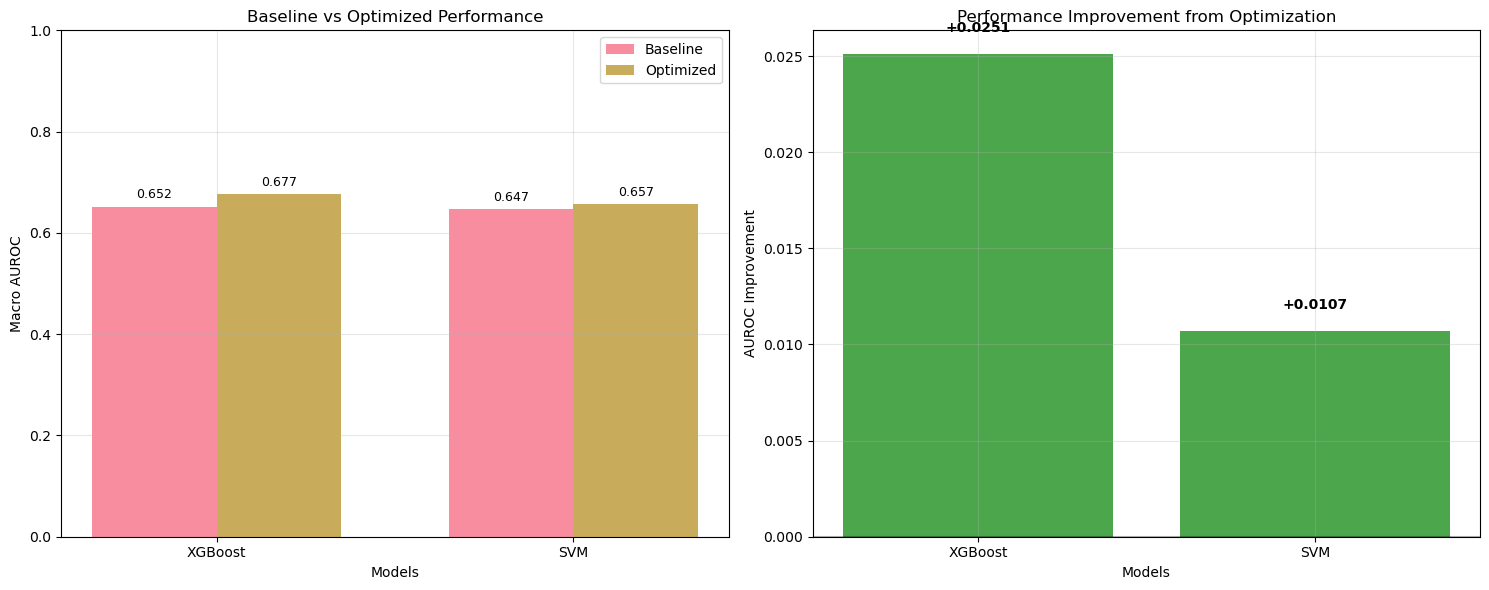

In [142]:
# Compare baseline vs optimized performance
print("BASELINE vs OPTIMIZED PERFORMANCE COMPARISON")
print("=" * 55)

# Ensure we use the correct model names
model_names_list = ['XGBoost', 'SVM']  # Explicitly define model names

comparison_data = []
for model_name in model_names_list:
    if model_name in cv_results and model_name in final_cv_results:
        baseline_score = cv_results[model_name]['auroc_mean']
        baseline_std = cv_results[model_name]['auroc_std']
        optimized_score = final_cv_results[model_name]['auroc_mean']
        optimized_std = final_cv_results[model_name]['auroc_std']
        improvement = optimized_score - baseline_score
        
        comparison_data.append({
            'Model': model_name,
            'Baseline_AUROC': f"{baseline_score:.4f} ± {baseline_std:.4f}",
            'Optimized_AUROC': f"{optimized_score:.4f} ± {optimized_std:.4f}",
            'Improvement': f"{improvement:+.4f}"
        })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart comparison
ax1 = axes[0]
baseline_scores = [cv_results[name]['auroc_mean'] for name in model_names_list if name in cv_results]
optimized_scores = [final_cv_results[name]['auroc_mean'] for name in model_names_list if name in final_cv_results]
available_model_names = [name for name in model_names_list if name in cv_results and name in final_cv_results]

x = np.arange(len(available_model_names))
width = 0.35

bars1 = ax1.bar(x - width/2, baseline_scores, width, label='Baseline', alpha=0.8)
bars2 = ax1.bar(x + width/2, optimized_scores, width, label='Optimized', alpha=0.8)

ax1.set_xlabel('Models')
ax1.set_ylabel('Macro AUROC')
ax1.set_title('Baseline vs Optimized Performance')
ax1.set_xticks(x)
ax1.set_xticklabels(available_model_names)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Improvement visualization
ax2 = axes[1]
improvements = [optimized_scores[i] - baseline_scores[i] for i in range(len(available_model_names))]
colors = ['green' if imp > 0 else 'red' for imp in improvements]
bars = ax2.bar(available_model_names, improvements, color=colors, alpha=0.7)

ax2.set_xlabel('Models')
ax2.set_ylabel('AUROC Improvement')
ax2.set_title('Performance Improvement from Optimization')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add value labels
for bar, imp in zip(bars, improvements):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + (0.001 if height > 0 else -0.003),
             f'{imp:+.4f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Baseline vs Optimized Performance Comparison

AttributeError: 'tuple' object has no attribute 'keys'

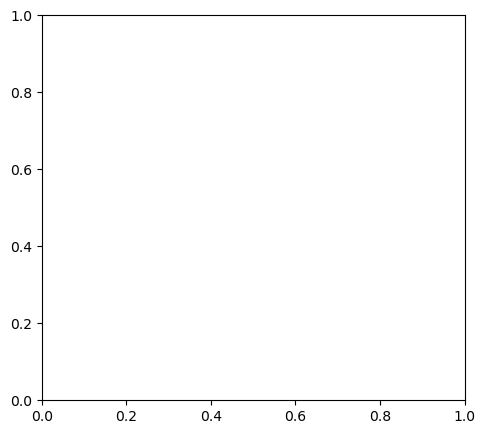

In [145]:
# Visualize cross-validation results
plt.figure(figsize=(12, 5))

# Box plot of AUROC scores
plt.subplot(1, 2, 1)
auroc_data = [cv_results[name]['auroc_scores'] for name in models.keys()]
plt.boxplot(auroc_data, labels=models.keys())
plt.ylabel('Macro AUROC')
plt.title('10-Fold Cross-Validation AUROC Distribution')
plt.grid(True, alpha=0.3)

# Bar plot of mean scores with error bars
plt.subplot(1, 2, 2)
names = list(models.keys())
means = [cv_results[name]['auroc_mean'] for name in names]
stds = [cv_results[name]['auroc_std'] for name in names]

plt.bar(names, means, yerr=stds, capsize=5, alpha=0.7)
plt.ylabel('Macro AUROC')
plt.title('Mean AUROC ± Standard Deviation')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, (mean, std) in enumerate(zip(means, stds)):
    plt.text(i, mean + std + 0.02, f'{mean:.3f}±{std:.3f}', 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [144]:
# Select best model based on mean AUROC
best_model_name = max(cv_results.keys(), key=lambda x: cv_results[x]['auroc_mean'])
best_model = models[best_model_name]

print(f"Best model: {best_model_name}")
print(f"Best AUROC: {cv_results[best_model_name]['auroc_mean']:.4f} ± {cv_results[best_model_name]['auroc_std']:.4f}")

# Train best model on full training set
X_final = X_train_scaled if best_model_name == 'SVM' else X_train
best_model.fit(X_final, y_train)
print(f"\n{best_model_name} trained on full training set")

TypeError: tuple indices must be integers or slices, not str

Top 20 Most Important Features (XGBoost):
         feature  importance
69    Feature 70    0.017879
5      Feature 6    0.016158
97    Feature 98    0.015541
121  Feature 122    0.015002
37    Feature 38    0.013087
120  Feature 121    0.013019
73    Feature 74    0.012826
16    Feature 17    0.012736
40    Feature 41    0.011997
72    Feature 73    0.011757
21    Feature 22    0.011582
89    Feature 90    0.011395
84    Feature 85    0.011364
56    Feature 57    0.011292
46    Feature 47    0.011132
54    Feature 55    0.011114
112  Feature 113    0.011035
71    Feature 72    0.011023
115  Feature 116    0.011002
49    Feature 50    0.010757


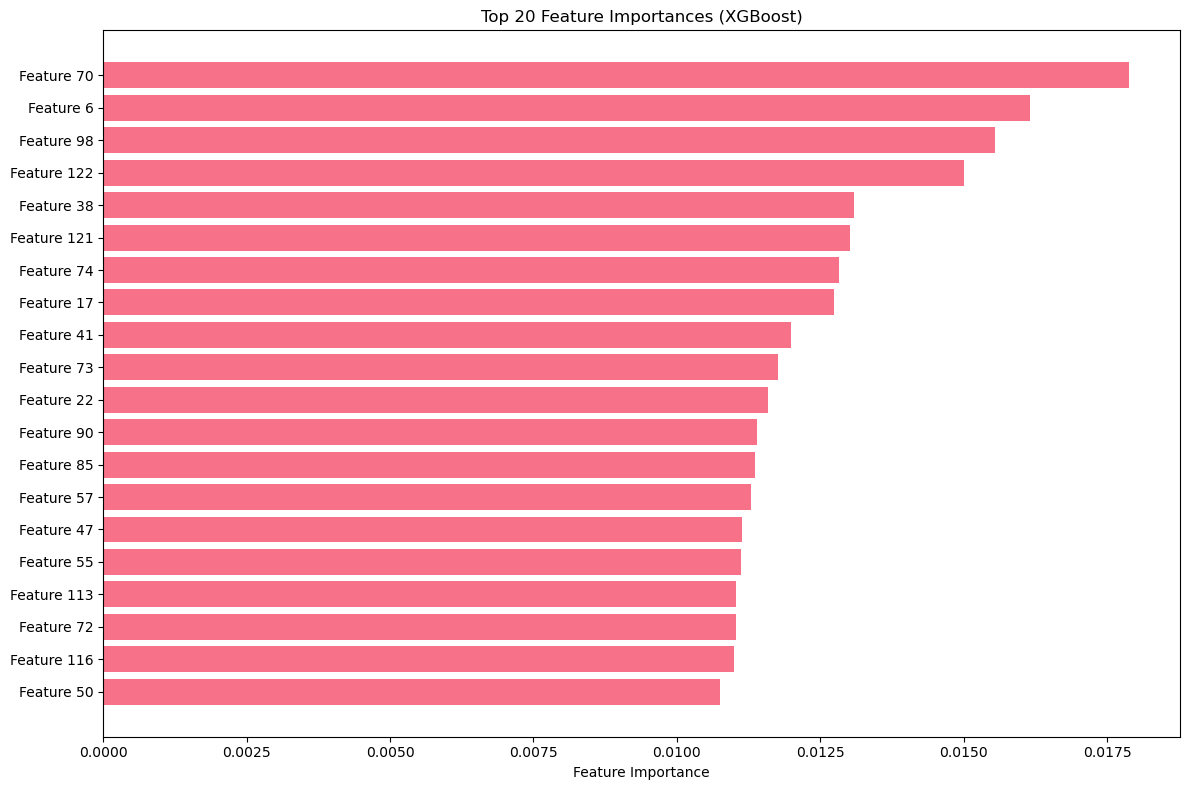

In [146]:
if best_model_name == 'XGBoost':
    # Get feature importance from XGBoost
    feature_importance = best_model.feature_importances_
    feature_names = X_train.columns
    
    # Create DataFrame for easier handling
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("Top 20 Most Important Features (XGBoost):")
    print(importance_df.head(20))
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    top_20 = importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['importance'])
    plt.yticks(range(len(top_20)), top_20['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importances (XGBoost)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
else:
    print(f"Feature importance not directly available for {best_model_name}")
    print("Consider using permutation importance for SVM interpretation")

In [147]:
# Make predictions for coaches with tenure class -1
X_pred_final = X_predict_scaled if best_model_name == 'SVM' else X_predict
predictions = best_model.predict(X_pred_final)
prediction_probabilities = best_model.predict_proba(X_pred_final)

# Create results DataFrame
prediction_results = df_predict[['Coach Name', 'Year']].copy()
prediction_results['Predicted_Tenure_Class'] = predictions
prediction_results['Prob_Short'] = prediction_probabilities[:, 0]
prediction_results['Prob_Medium'] = prediction_probabilities[:, 1] 
prediction_results['Prob_Long'] = prediction_probabilities[:, 2]
prediction_results['Max_Probability'] = prediction_probabilities.max(axis=1)

# Sort by prediction confidence
prediction_results = prediction_results.sort_values('Max_Probability', ascending=False)

print(f"Predictions for {len(prediction_results)} coaches with unknown tenure:")
print("\n" + "="*80)
print(prediction_results.to_string(index=False, float_format='%.3f'))

# Prediction distribution
print(f"\nPrediction distribution:")
pred_counts = pd.Series(predictions).value_counts().sort_index()
for cls, count in pred_counts.items():
    class_name = ['Short (≤2y)', 'Medium (3-4y)', 'Long (5+y)'][cls]
    print(f"Class {cls} ({class_name}): {count} coaches")

Predictions for 21 coaches with unknown tenure:

           Coach Name  Year  Predicted_Tenure_Class  Prob_Short  Prob_Medium  Prob_Long  Max_Probability
       Mike Macdonald  2024                       2       0.049        0.197      0.754            0.754
         Kellen Moore  2025                       0       0.723        0.110      0.166            0.723
         Jim Harbaugh  2024                       0       0.722        0.188      0.090            0.722
      Kevin O'Connell  2022                       2       0.109        0.203      0.688            0.688
      Jonathan Gannon  2023                       1       0.115        0.652      0.233            0.652
       Brian Callahan  2024                       2       0.213        0.142      0.645            0.645
         DeMeco Ryans  2023                       2       0.099        0.263      0.637            0.637
         Pete Carroll  2025                       1       0.081        0.631      0.289            0.631
      

In [148]:
print("=" * 60)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("=" * 60)

print(f"\nDataset Statistics:")
print(f"- Training instances: {len(X_train)}")
print(f"- Features: {X_train.shape[1]}")
print(f"- Classes: 3 (Short: ≤2y, Medium: 3-4y, Long: 5+y)")
print(f"- Prediction instances: {len(X_predict)}")

print(f"\nCross-Validation Results (10-fold stratified):")
for name, results in cv_results.items():
    print(f"- {name}: {results['auroc_mean']:.4f} ± {results['auroc_std']:.4f} macro AUROC")

print(f"\nBest Model: {best_model_name}")
print(f"Best Performance: {cv_results[best_model_name]['auroc_mean']:.4f} ± {cv_results[best_model_name]['auroc_std']:.4f} macro AUROC")

print(f"\nPredictions Made: {len(prediction_results)} coaches")
print("=" * 60)

FINAL MODEL PERFORMANCE SUMMARY

Dataset Statistics:
- Training instances: 636
- Features: 150
- Classes: 3 (Short: ≤2y, Medium: 3-4y, Long: 5+y)
- Prediction instances: 21

Cross-Validation Results (10-fold stratified):
- XGBoost: 0.6521 ± 0.0600 macro AUROC
- SVM: 0.6465 ± 0.0607 macro AUROC

Best Model: XGBoost
Best Performance: 0.6521 ± 0.0600 macro AUROC

Predictions Made: 21 coaches


In [149]:
# Save prediction results
prediction_results.to_csv('coaching_tenure_predictions.csv', index=False)
print("Predictions saved to: coaching_tenure_predictions.csv")

# Save model performance summary
summary_data = []
for name, results in cv_results.items():
    summary_data.append({
        'Model': name,
        'Mean_AUROC': results['auroc_mean'],
        'Std_AUROC': results['auroc_std'],
        'Is_Best': name == best_model_name
    })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('model_performance_summary.csv', index=False)
print("Model performance summary saved to: model_performance_summary.csv")

Predictions saved to: coaching_tenure_predictions.csv
Model performance summary saved to: model_performance_summary.csv
